## Chapter 14: Convolutional Neural Networks

# 14.2 Edge histogram based features

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from mlrefined_libraries import convnets_library as convlib
from mlrefined_libraries import basics_library as baslib
import autograd.numpy as np
import pandas as pd
#import cv2
from PIL import Image
import pickle
import gzip
import time

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 14.2.1 Efficient image represenation: raw pixels vs. edges

To perform supervised or unsupervised tasks on image data, like object detection or image compression (dimension reduction) one could always use the (raw) pixel values directly as features. This naive approach however has been shown experimentally to produce low quality results in virtually all machine learning tasks involving natural images[\*](#footnotes). An alternative, more efficient approach would be to represent an image by making use of its edge content, as illustrated in Figure 1 which shows an image (left panel) along with a corresponding image comprised of its most prominent edges (right panel).

<figure>
<img src="../../mlrefined_images/convnet_images/edge_detection.png" width="90%" height="auto"/>
<figcaption> <strong>Figure 1:</strong> <em> (left panel) A natural image (in this instance of the two creators/writers of the television show 'South Park' (this image is reproduced with permission of Jason Marck). (right panel) The edge-detected version of this image, where the bright yellow pixels indicate large edge content, still describes the scene very well (in the sense that we can still tell there are two people in the image) using only a fraction of the information contained in the original image. Note that edges have been colored yellow for visualization purposes only.</em>
</figcaption>
</figure>

The edge-detected image in the right panel of Figure 1 is an efficient representation of the original image in the left panel in the sense that we can still tell what the image contains while throwing away a lot of information from the majority of the pixels that do not belong to any edges.

This is true in general: the distinguishing information in a natural image is largely contained in the relatively small number of edges in an image [[1,2]](#bib_cell). Interestingly, this fact is also confirmed by visual studies performed largely on frogs, cats, and primates, where a subject is shown visual stimuli while electrical impulses are recorded in a small area in the subject's brain where visual information is processed. These studies have determined that individual neurons involved in early stages of visual processing roughly operate by identifying edges [[3,4]](#bib_cell). Each neuron therefore acts as a small "edge detector," locating edges in an image of a specific orientation and thickness, as shown in Figure 2. It is thought that by combining and processing these edge detected images, humans and other mammals "see."

<figure>
<img src="../../mlrefined_images/convnet_images/neuron.png" width="80%" height="auto"/>
<figcaption> <strong>Figure 2:</strong> <em> Visual information is processed in an area of the brain where each neuron detects in the observed scene edges of a specific orientation and width. It is thought that what we (and other mammals) "see" is a processed interpolation of these edge detected images. </em>
</figcaption>
</figure>

## 14.2.2 Edge histogram features 

Motivated by our discussion in the previous subsection, here we design a feature extraction scheme based on the information provided by edges of different orientation within an image. This is indeed the basis of many popular *engineered* features, including Histogram of Oriented Gradients (HoG) [[5]](#bib_cell) and Scale-Invariant Feature Transform (SIFT) [[6]](#bib_cell).      

Edges can be detected within an image using convolution. Recall from our post on convolution operation, that convolving an image with appropriate horizontal and vertical kernels gives image gradients in those directions where large pixel values indicate high edge content. Additional kernels can be added to the mix to detect edges that are not horizontal /vertical but are at an incline. For example, the eight kernels shown below each correspond to one of eight equally (angularly) spaced edge orientations, starting from 0 degrees with seven additional orientations at increments of 45 degrees.

<IPython.core.display.Javascript object>


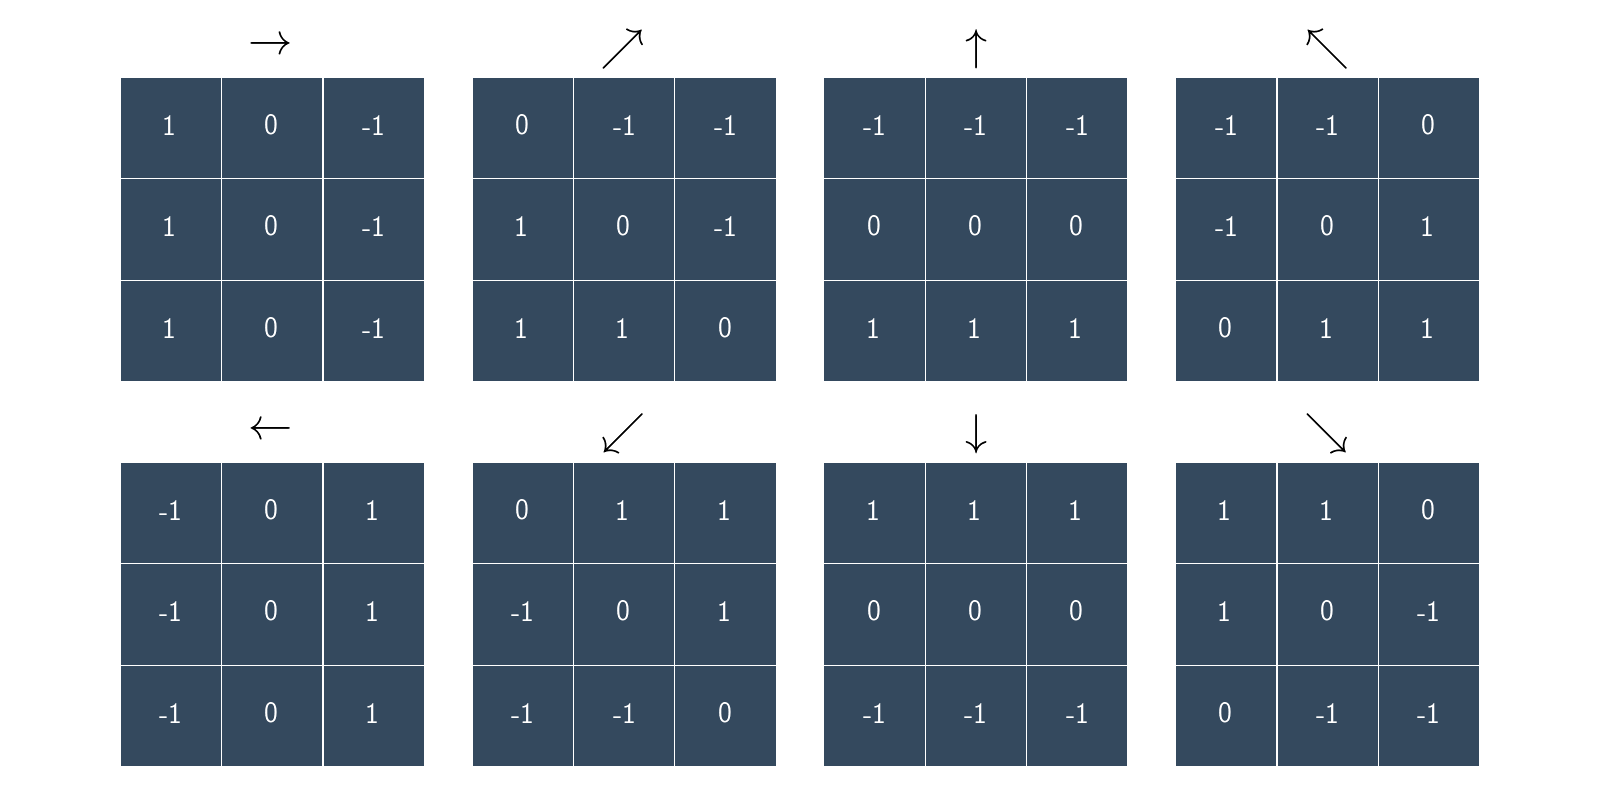

In [21]:
convlib.image_viz.show_conv_kernels()

<figure>
<figcaption> <strong>Figure 3:</strong> <em> Eight $3\times 3$ convolution kernels, each capturing edges of a particular orientation (shown on top of the kernel) when convolved with an image.</em>
</figcaption>
</figure>

To capture the total 'edge content' of an image in each direction, we convolve it with the appropriate kernel, pass the results through a rectified linear unit (ReLU) to remove negative entries, and sum up the remaining positive pixel values. Denoting the input image by $x$ and the convolution kernels by $w_1,\,\ldots,\,w_8$, this gives us eight features $f_1,\,\ldots,\,f_8$ to represent $x$, defined as 

\begin{equation}
f_{i}=\underset{\text{all pixels}}{\sum}\text{max}\left(0,\,w_{i}*x\right) \qquad i=1,\,\ldots,\,8
\end{equation}

We use ReLU in (1) so that large positive values in $w_{i}*x$ do not get canceled out by possible large negative values in it. Notice, we are not discarding any information by removing negative entries in $w_{i}*x$. In fact it can be easily verified that those negative entries are identical to the positive entries in $w_{j}*x$, where $w_i$ and $w_j$ are kernels associated to opposing directions.

Stacking all $f_i$'s together into a single vector $\mathbf{f}$ we now have a feature representation for $x$ in the form of an edge histogram which is typically normalized to have unit length (in the $\ell_2$ or $\ell_1$ sense). In the Python cell below we plot an input image (in this case a circle), along with the convolution plots of the input image with each of the eight kernels in Figure 3 (after passing through ReLU), and the final histogram representation of the image in the last column.   

<IPython.core.display.Javascript object>


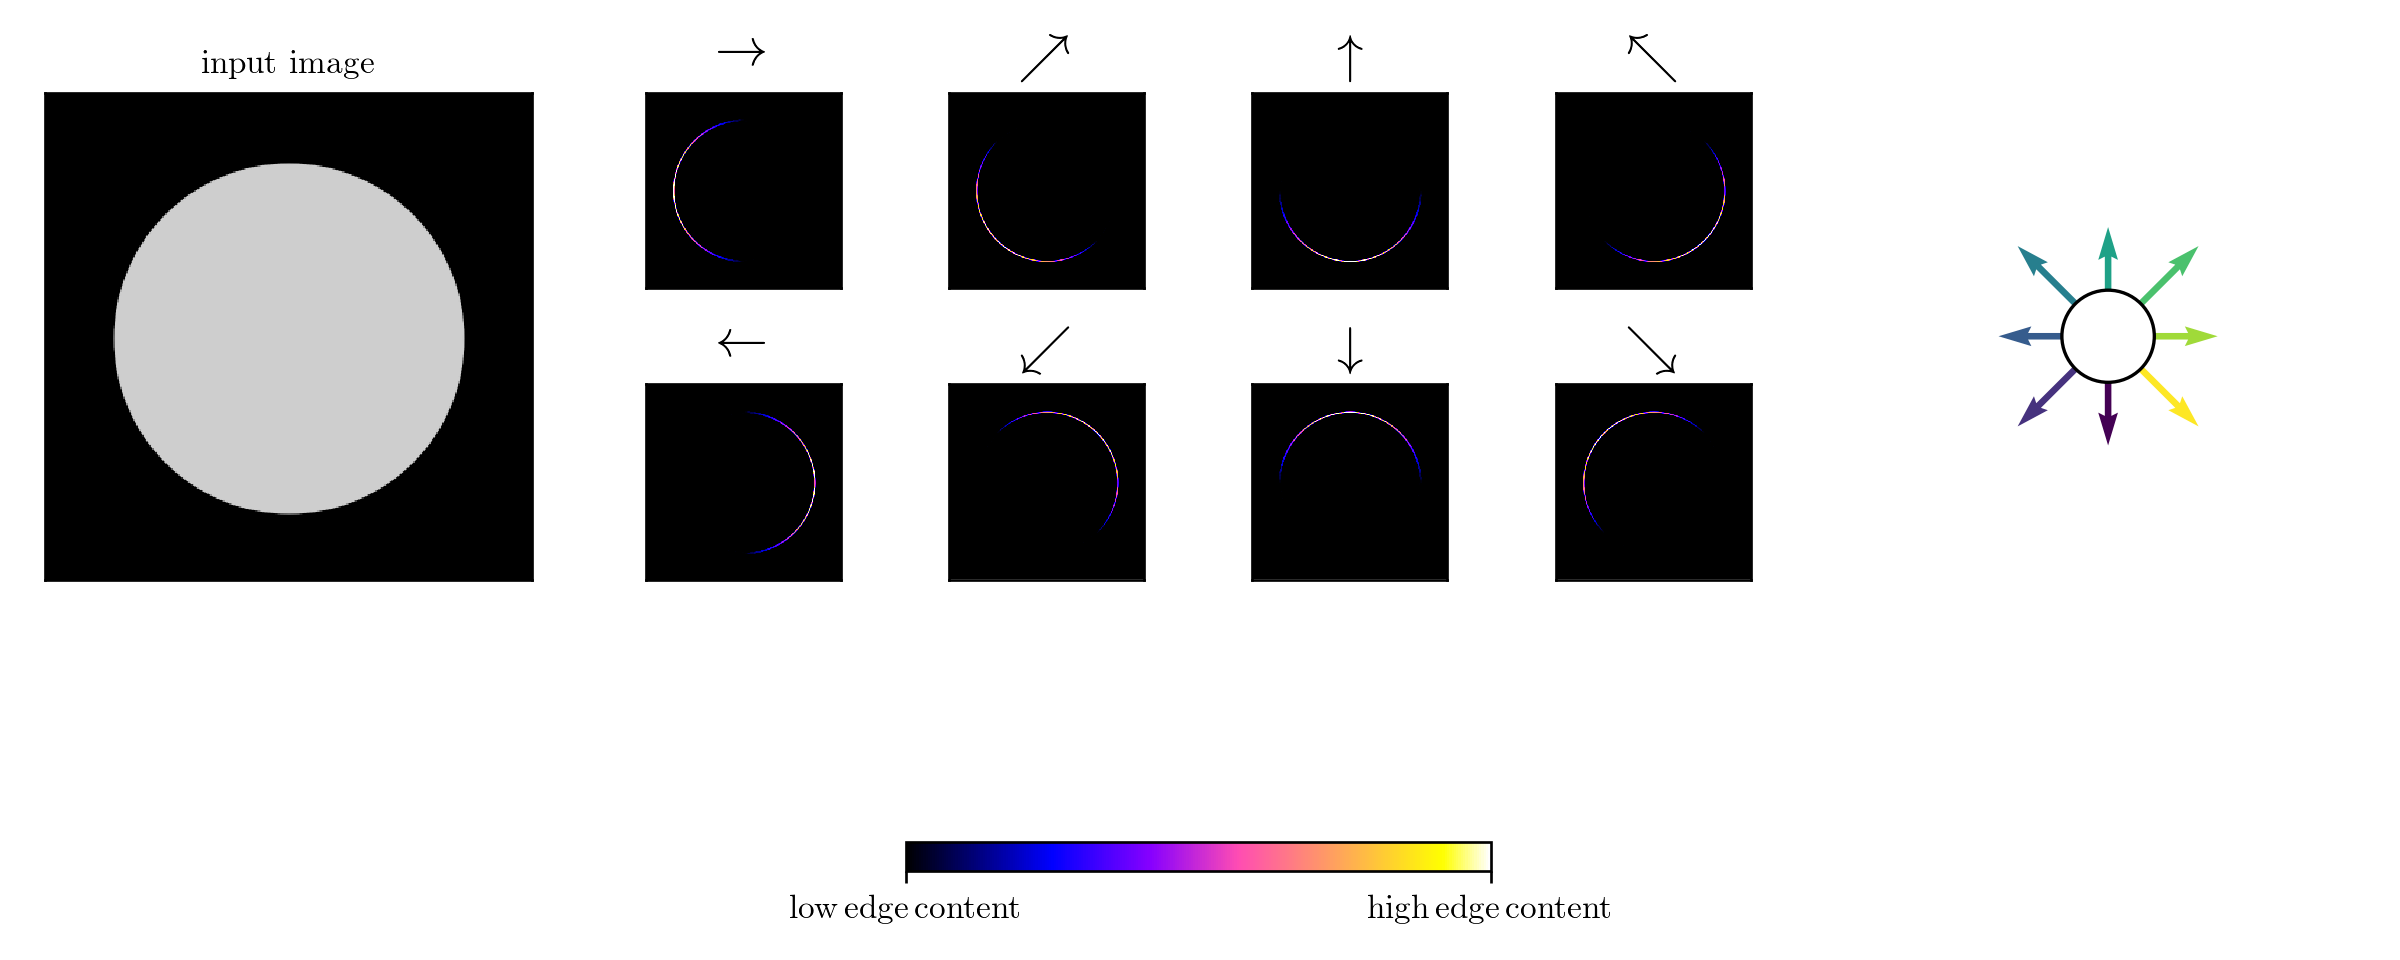

In [2]:
# load image
#image = cv2.imread('../../mlrefined_images/convnet_images/circle.png',0)
image = Image.open('../../mlrefined_images/convnet_images/circle.png').convert('L')


# compute and plot convolution images
convlib.image_viz.show_conv_images(image)

The feature extractor we have designed so far may work well in overly simplistic scenarios, e.g. distinguishing a circle from a triangle or a square. But even then it fails to distinguish between a circle and a star, as their feature representations end up to be identical due to the symmetry of both shapes.

<IPython.core.display.Javascript object>


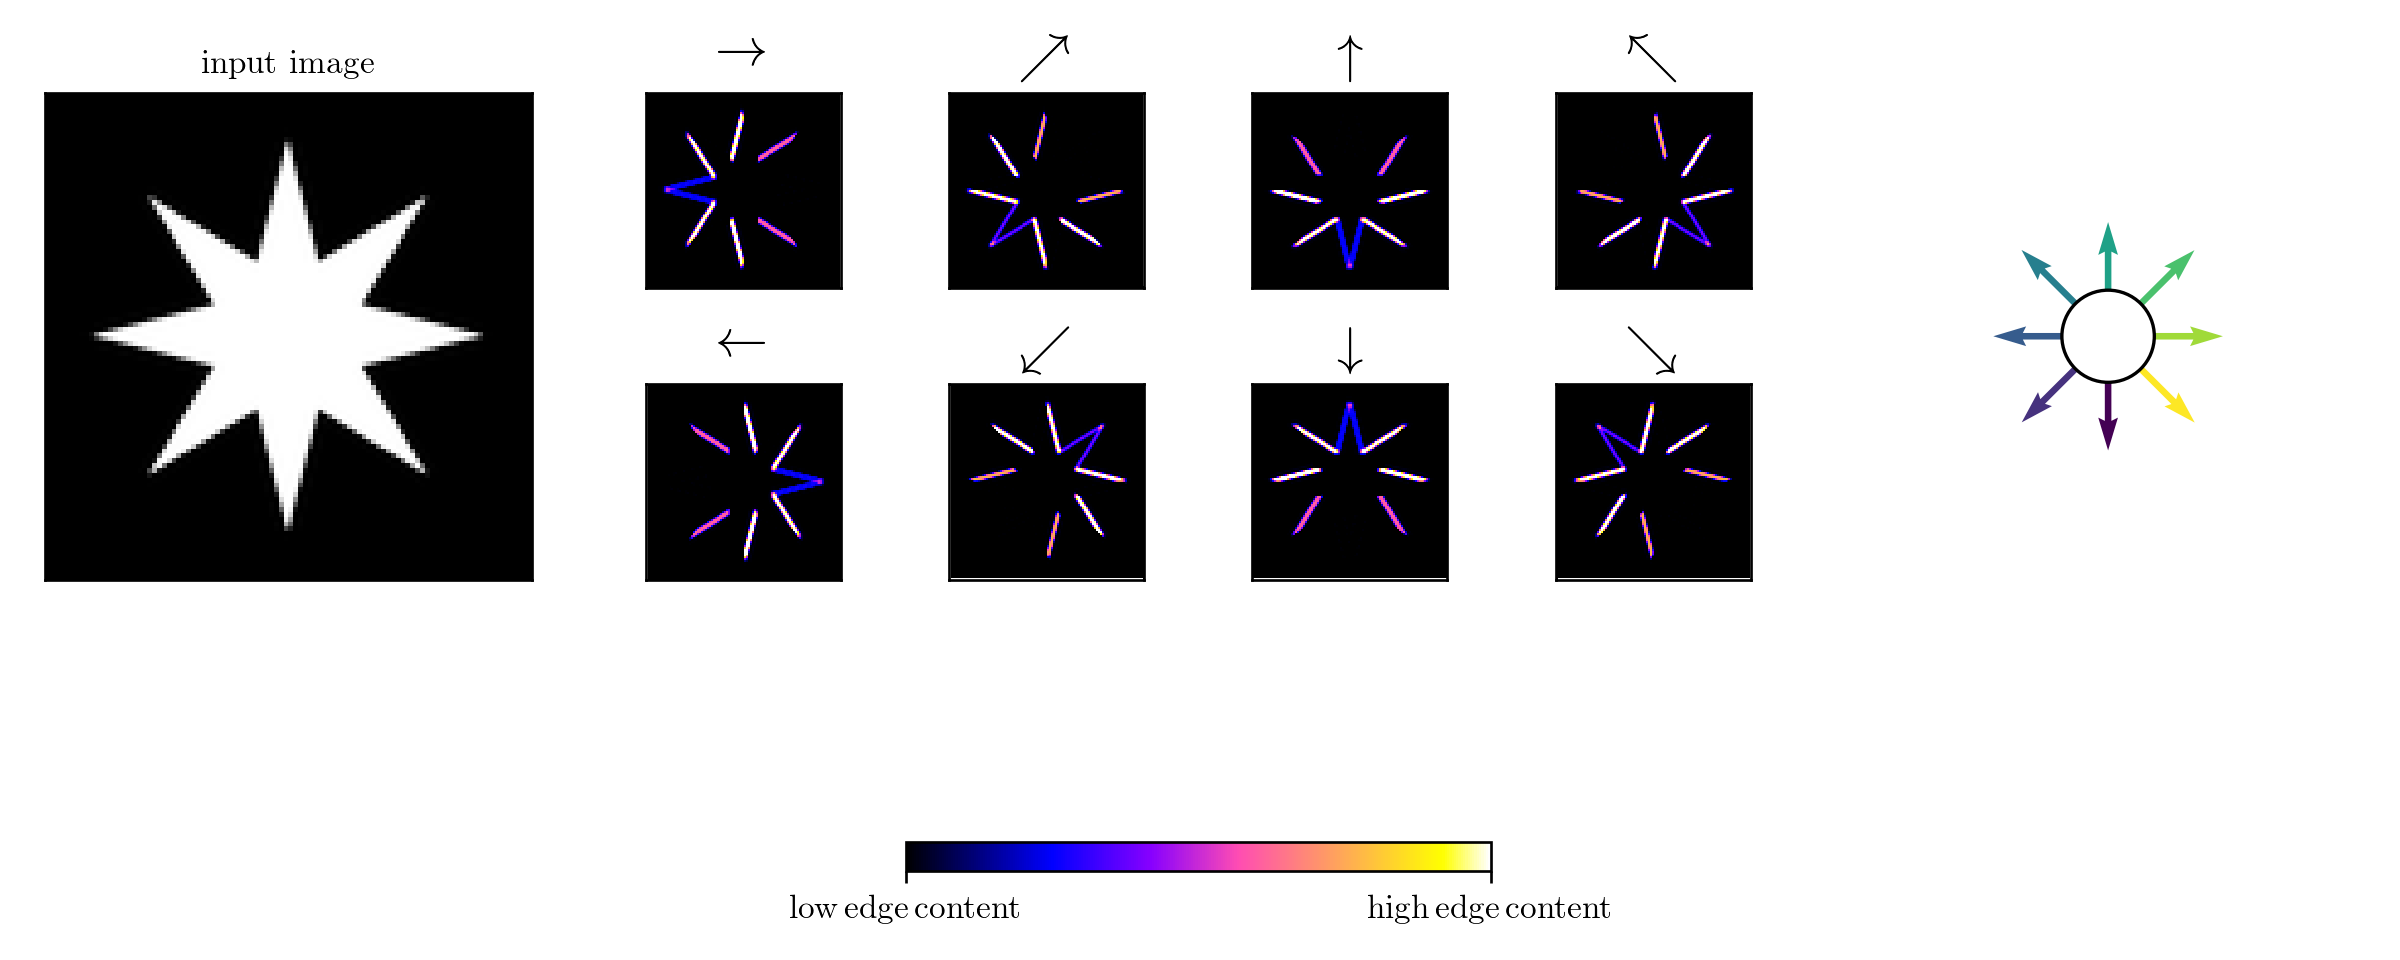

In [3]:
# load image
#image = cv2.imread('../../mlrefined_images/convnet_images/star.png', 0)

# downsample the image (if too large)
#image = cv2.resize(image, (0,0), fx=0.25, fy=0.25)

image = Image.open('../../mlrefined_images/convnet_images/star.png').convert('L')
image = image.resize((100,100), Image.ANTIALIAS)

# compute and plot convolution images
convlib.image_viz.show_conv_images(image)

Real images used in practice are significantly more complicated than these simplistic geometrical shapes and summarizing them using just eight features would be extremely ineffective. To fix this issue, instead of computing the edge histogram features over the entire image as done in (1), we break the image into relatively small patches (that may be overlapping), compute features for each patch

\begin{equation}
f_{i,\,j}=\underset{j\,\text{th patch}}{\sum}\text{max}\left(0,\,w_{i}*x\right) \qquad i=1,\,\ldots,\,8
\end{equation}

and then concatenate the results to arrive at the final feature representation. This process, i.e., breaking the image into small patches and representing each patch via the sum of its pixels, is referred to as *pooling* (or more accurately sum-pooling) in the parlance of machine learning and computer vision, and is shown pictorially in Figure 4 for an example matrix. 

<figure>
<img src="../../mlrefined_images/convnet_images/pooling.png" width="90%" height="auto"/>
<figcaption> <strong>Figure 4:</strong> <em> Pooling illustrated. The $6\times 6$ matrix on the left is pooled using four non-overlapping $3 \times 3$ patches, producing the $2 \times 2$ matrix on the right.</em>
</figcaption>
</figure>

## 14.2.3 Pooling: Python implementation

Procedurally, the pooling operation is similar to convolution with only two differences. First, with pooling the sliding window can jump multiple pixels at a time depending on how much overlap is required between adjacent windows/patches. The number of pixels the sliding window is shifted is typically referred to as the *stride*. Notice, with convolution the stride is always 1.

The second difference between convolution and pooling is how the content of the sliding window is processed and then summarized as a single value in each case. Recall that with convolution, the input function to the <code>sliding_window</code> module computes the sum of the entry-wise product between the window and a kernel. With pooling on the other hand, there is no kernel and we simply sum up all the pixels inside the kernel.

Slightly modifying the <code>sliding_window</code> module from our post on convolution operation to include <code>stride</code> as an input parameter, we have

In [4]:
def sliding_window(image, window_size, func, stride):
    
    # grab image size, set container for results
    image_size = np.shape(image)[0]
    results = []
    
    # slide window over input image
    for i in np.arange(0, image_size - window_size + 1, stride):
        for j in np.arange(0, image_size - window_size + 1, stride):
            # extract window from the image
            window = image[i:i+window_size,j:j+window_size]
            
            # process using the input 'func' (here the convolution function)
            processed_window = func(window)
            
            # store the results
            results.append(processed_window)
    
    # return results in numpy array format
    return np.array(results)

Finally to pool an image one can call <code>sliding_window</code> with

In [5]:
pool_function = lambda window: np.sum(window) 

as the input function.

## 14.2.4 Putting all pieces together: the complete feature extraction pipeline

Putting together all the components discussed in the previous subsection, i.e., convolution, ReLU, and pooling, we show the end-to-end image feature extraction pipeline in Figure 5.

<figure>
<img src="../../mlrefined_images/convnet_images/pipeline2.png" width="90%" height="auto"/>
<figcaption> <strong>Figure 5:</strong> <em> Feature extraction pipeline. For compactness only four (out of eight) kernels are shown. </em>
</figcaption>
</figure>

The module <code>make_feature_map</code> below takes in a single image and a single kernel, computes their convolution, and pool the result after passing through a ReLU module.       

In [6]:
def make_feature_map(image, kernel):
    
    # parameters for transform
    kernel_size = kernels[0].shape[0]
    pool_kernel_size = 6
    stride = 3
    
    # pad image with zeros
    padded_image = self.pad_image(image,kernel_size)
        
    # window image
    feature_map = self.sliding_window_image(padded_image,kernel_size,stride = 1,func = self.conv_function)
        
    # reshape convolution feature map into array
    feature_map = np.reshape(feature_map,(np.shape(image)))
        
    # now shove result through nonlinear activation
    feature_map = self.activation(feature_map)

    #### now pool / downsample feature map, first window then pool on each window
    max_pool = self.sliding_window_image(feature_map,pool_kernel_size,stride = stride,func = self.pool_function)

    # reshape into new tensor
    max_pool = np.reshape(max_pool, (int((np.size(max_pool))**(0.5)),int((np.size(max_pool))**(0.5))))

    return max_pool

Notice how we used the same module <code>sliding_window</code> to perform both convolution and pooling, albeit with different stride and processing function.    

To extract the full feature representation of entire image dataset we can use <code>make_feature_map</code> and construct one feature map at a time by looping through all images, and for each image constructing a feature map for each convolution kernel (again by explicitly looping through the kernels). This is implemented in the <code>conv_layer</code> module below.

In [27]:
 # main convolution layer definition
def conv_layer(self,images,kernels):
    #### create image tensor from input images
    image_tensor = np.reshape(images,(np.shape(images)[0],int((np.shape(images)[1])**(0.5)),int( (np.shape(images)[1])**(0.5))),order = 'F')

    #### loop over each image, shove through filters and make feature maps, then downsample and pool
    new_tensors = []

    #### loop over images
    for image in image_tensor:
        #### loop over kernels and construct feature map for each kernel
        downsampled_feature_maps = []
        for kernel in kernels:
            self.kernel = kernel
            downsampled_map = self.make_feature_map(image,kernel)
            downsampled_feature_maps.append(downsampled_map)
            
        ## re-shape downsampled_feature_maps and store
        new_tensors.append(downsampled_feature_maps)

    # reshape new tensor properly
    new_tensors = np.array(new_tensors)
    new_tensors = np.reshape(new_tensors, (np.shape(new_tensors)[0],np.shape(new_tensors)[1],np.shape(new_tensors)[2]*np.shape(new_tensors)[3]))
    new_tensors = np.reshape(new_tensors, (np.shape(new_tensors)[0],np.shape(new_tensors)[1]*np.shape(new_tensors)[2]),order = 'F')

    return new_tensors

In [12]:
class naive_conv_layer:
    '''
    A simple convnet module.  Here we calculate feature maps exactly one at a time, using
    a host of nested for-loops.  This means computation will be quite slow!  However this
    can still be used in theory as a fixed convolutional feature extractor or as a convolutional
    layer in a convnet (where the kernels are learned).
    '''   
    
    # a convolution function
    def conv_function(self,window):
        conv = np.sum(self.kernel*window)
        return conv
    
    # a pooling function
    def pool_function(self,window):
        pool = np.max(window)
        return pool

    # activation function
    def activation(self,window):
        a = np.maximum(0,window)
        return a
    
    # pad image with appropriate number of zeros for convolution
    def pad_image(self,image,kernel_size):
        odd_nums = np.array([int(2*n + 1) for n in range(100)])
        pad_val = np.argwhere(odd_nums == kernel_size)[0][0]
        image_padded = np.zeros((np.shape(image) + 2*pad_val))
        image_padded[pad_val:-pad_val,pad_val:-pad_val] = image
        return image_padded          
    
    # sliding window function, convolution or pooling done on each window
    def sliding_window_image(self,image,window_size,stride,func):
        # grab image size, set container for results
        image_size = np.shape(image)[0]
        results = []

        # slide window over input image with given window size / stride and function
        for i in np.arange(0, image_size - window_size + 1, stride):
            for j in np.arange(0, image_size - window_size + 1, stride):
                # now we have a window from our image, and use the desired 'func' to process it
                window = image[i:i+window_size,j:j+window_size]

                # process using input func
                processed_window = func(window)
                results.append(processed_window)

        # array-afy results
        results = np.array(results)

        # return results in numpy array format
        return results
    
    # make feature map for input inage and kernel
    def make_feature_map(self,image,kernel):
        # parameters for transform
        kernel_size = kernels[0].shape[0]
        pool_kernel_size = 6
        stride = 3
    
        # pad image with zeros
        padded_image = self.pad_image(image,kernel_size)
        
        # window image
        feature_map = self.sliding_window_image(padded_image,kernel_size,stride = 1,func = self.conv_function)
        
        # reshape convolution feature map into array
        feature_map = np.reshape(feature_map,(np.shape(image)))
        
        # now shove result through nonlinear activation
        feature_map = self.activation(feature_map)

        #### now pool / downsample feature map, first window then pool on each window
        max_pool = self.sliding_window_image(feature_map,pool_kernel_size,stride = stride,func = self.pool_function)

        # reshape into new tensor
        max_pool = np.reshape(max_pool, (int((np.size(max_pool))**(0.5)),int((np.size(max_pool))**(0.5))))

        return max_pool
        
    # main convolution layer definition
    def conv_layer(self,images,kernels):
        #### create image tensor from input images
        image_tensor = np.reshape(images,(np.shape(images)[0],int((np.shape(images)[1])**(0.5)),int( (np.shape(images)[1])**(0.5))),order = 'F')

        #### loop over each image, shove through filters and make feature maps, then downsample and pool
        new_tensors = []

        #### loop over images
        for image in image_tensor:
            #### loop over kernels and construct feature map for each kernel
            downsampled_feature_maps = []
            for kernel in kernels:
                self.kernel = kernel
                downsampled_map = self.make_feature_map(image,kernel)
                downsampled_feature_maps.append(downsampled_map)
            
            ## re-shape downsampled_feature_maps and store
            new_tensors.append(downsampled_feature_maps)

        # reshape new tensor properly
        new_tensors = np.array(new_tensors)
        new_tensors = np.reshape(new_tensors, (np.shape(new_tensors)[0],np.shape(new_tensors)[1],np.shape(new_tensors)[2]*np.shape(new_tensors)[3]))
        new_tensors = np.reshape(new_tensors, (np.shape(new_tensors)[0],np.shape(new_tensors)[1]*np.shape(new_tensors)[2]),order = 'F')

        return new_tensors

## 14.2.5 Efficient tensor-based implementation of the feature extractor 

While the con_layer coded up in the previous subsection works accurately, in practice its Pyhton implemetation is extremely inefficient, particularly for meduim- to large-sized datasets, due to the nested for-loops involved!
By carefully thinking about how convolutional feature maps are constructed on a set of images we can re-write the conv_layer in a much more efficient manner by employing ``tensors`` - i.e., three (and higher) dimensional matrices.  The idea here, as shown pictorially in the right panel of Figure 7, is to process the entire stack (``tensor``) of images simultaneously, thereby minimizing the number of explicit for-loops required.

<figure>
<img src="../../mlrefined_images/convnet_images/naive_vs_tensor.png" width="80%" height="auto"/>
<figcaption> <strong>Figure 7:</strong> <em> </em>
</figcaption>
</figure>

In [8]:
class tensor_conv_layer:    
    # convolution function
    def conv_function(self,tensor_window):
        tensor_window = np.reshape(tensor_window,(np.shape(tensor_window)[0],np.shape(tensor_window)[1]*np.shape(tensor_window)[2]))
        t = np.dot(self.kernels,tensor_window.T)
        return t

    # pooling / downsampling parameters
    def pool_function(self,tensor_window):
        t = np.max(tensor_window,axis = (1,2))
        return t

    # activation 
    def activation(self,tensor_window):
        return np.maximum(0,tensor_window)

    # pad image with appropriate number of zeros for convolution
    def pad_tensor(self,tensor,kernel_size):
        odd_nums = np.array([int(2*n + 1) for n in range(100)])
        pad_val = np.argwhere(odd_nums == kernel_size)[0][0]
        tensor_padded = np.zeros((np.shape(tensor)[0], np.shape(tensor)[1] + 2*pad_val,np.shape(tensor)[2] + 2*pad_val))
        tensor_padded[:,pad_val:-pad_val,pad_val:-pad_val] = tensor
        return tensor_padded    
    
    # sliding window for image augmentation
    def sliding_window_tensor(self,tensor,window_size,stride,func):
        # grab image size, set container for results
        image_size = np.shape(tensor)[1]
        results = []
        
        # slide window over input image with given window size / stride and function
        for i in np.arange(0, image_size - window_size + 1, stride):
            for j in np.arange(0, image_size - window_size + 1, stride):
                # take a window of input tensor
                tensor_window =  tensor[:,i:i+window_size, j:j+window_size]
                
                # now process entire windowed tensor at once
                tensor_window = np.array(tensor_window)
                yo = func(tensor_window)

                # store weight
                results.append(yo)
        
        # re-shape properly
        results = np.array(results)
        results = results.swapaxes(0,1)
        if func == self.conv_function:
            results = results.swapaxes(1,2)
        return results 

    # make feature map
    def make_feature_tensor(self,tensor):
        # create feature map via convolution --> returns flattened convolution calculations
        conv_stride = 1
        feature_tensor = self.sliding_window_tensor(tensor,self.kernel_size,conv_stride,self.conv_function) 

        # re-shape convolution output ---> to square of same size as original input
        num_filters = np.shape(feature_tensor)[0]
        num_images = np.shape(feature_tensor)[1]
        square_dim = int((np.shape(feature_tensor)[2])**(0.5))
        feature_tensor = np.reshape(feature_tensor,(num_filters,num_images,square_dim,square_dim))
        
        # shove feature map through nonlinearity
        feature_tensor = self.activation(feature_tensor)

        # pool feature map --- i.e., downsample it
        pool_stride = 3
        pool_window_size = 6
        downsampled_feature_map = []
        for t in range(np.shape(feature_tensor)[0]):
            temp_tens = feature_tensor[t,:,:,:]
            d = self.sliding_window_tensor(temp_tens,pool_window_size,pool_stride,self.pool_function)
            downsampled_feature_map.append(d)
        downsampled_feature_map = np.array(downsampled_feature_map)

        # return downsampled feature map --> flattened
        return downsampled_feature_map

    # our normalization function
    def normalize(self,data,data_mean,data_std):
        normalized_data = (data - data_mean)/(data_std + 10**(-5))
        return normalized_data

    # convolution layer
    def conv_layer(self,tensor,kernels):
        #### prep input tensor #####
        # pluck out dimensions for image-tensor reshape
        num_images = np.shape(tensor)[0]
        num_kernels = np.shape(kernels)[0]
        
        # create tensor out of input images (assumed to be stacked vertically as columns)
        tensor = np.reshape(tensor,(np.shape(tensor)[0],int((np.shape(tensor)[1])**(0.5)),int( (np.shape(tensor)[1])**(0.5))),order = 'F')

        # pad tensor
        kernel = kernels[0]
        self.kernel_size = np.shape(kernel)[0]
        padded_tensor = self.pad_tensor(tensor,self.kernel_size)

        #### prep kernels - reshape into array for more effecient computation ####
        self.kernels = np.reshape(kernels,(np.shape(kernels)[0],np.shape(kernels)[1]*np.shape(kernels)[2]))
        
        #### compute convolution feature maps / downsample via pooling one map at a time over entire tensor #####
        # compute feature map for current image using current convolution kernel
        feature_tensor = self.make_feature_tensor(padded_tensor)

        feature_tensor = feature_tensor.swapaxes(0,1)
        feature_tensor = np.reshape(feature_tensor, (np.shape(feature_tensor)[0],np.shape(feature_tensor)[1]*np.shape(feature_tensor)[2]),order = 'F')
        
        return feature_tensor

### A speed test in evaluating the convolution layers implemented above

Lets compare the speeds of our naive versus tensor-based convolution layer implementations using the face detection image dataset and the set of edge detecting kernels given below.

In [9]:
edge_detection_kernels = np.array([
       [[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]],

       [[-1, -1,  0],
        [-1,  0,  1],
        [ 0,  1,  1]],
    
        [[-1,  0,  1],
        [-1,  0,  1],
        [-1,  0,  1]],

       [[ 0,  1,  1],
        [-1,  0,  1],
        [-1, -1,  0]],

       [[ 1,  0, -1],
        [ 1,  0, -1],
        [ 1,  0, -1]],

       [[ 0, -1, -1],
        [ 1,  0, -1],
        [ 1,  1,  0]],

       [[ 1,  1,  1],
        [ 0,  0,  0],
        [-1, -1, -1]],

       [[ 1,  1,  0],
        [ 1,  0, -1],
        [ 0, -1, -1]]])          

Lets try it out.  Here we will use the ``datetime`` library to do this.

In [13]:
# declare instances of each convolution function
naive_conv_test = naive_conv_layer()
tensor_conv_test = tensor_conv_layer()

In [14]:
kernels = np.random.randn(1,3,3)

Load in the face detection dataset.

In [15]:
# load data
datapath = '../../mlrefined_datasets/convnet_datasets/feat_face_data.csv'
data = np.loadtxt(datapath,delimiter = ',')

# import data and reshape appropriately
x = data[:,:-1]
y = data[:,-1:1]

# take a small number of examples for the speed test
x = x[:1000,:]
y = y[:1000]

---------

To give a sense of just how much edge-based features improve our ability to detect visual objects we now perform a simple experiment on a medium-sized face detection dataset. This data consists of $3000$ cropped $28 \times 28$ images of faces (taken from [[7]](#bib_cell)) and $7000$ equal sized non-face images (taken from various images not containing faces), a sample of which is shown below. 

In [16]:
 def load_data(csvname):
    # load in data
    data = np.asarray(pd.read_csv(csvname))

    # import data and reshape appropriately
    X = data[:,0:-1]
    y = data[:,-1]
    y.shape = (len(y),1)
    
    X_square = np.zeros((len(y),28,28))
    for i in range(0,len(y)):
        X_square[i,:,:] = np.reshape(X[i,:],(28,28),1)
    
    # pad data with ones for more compact gradient computation
    o = np.ones((np.shape(X)[0],1))
    X = np.concatenate((o,X),axis = 1)
    X = X.T
    
    return X,X_square,y

In [17]:
# load data
X,X_square, y = load_data('../../mlrefined_datasets/convnet_datasets/feat_face_data.csv')

<IPython.core.display.Javascript object>


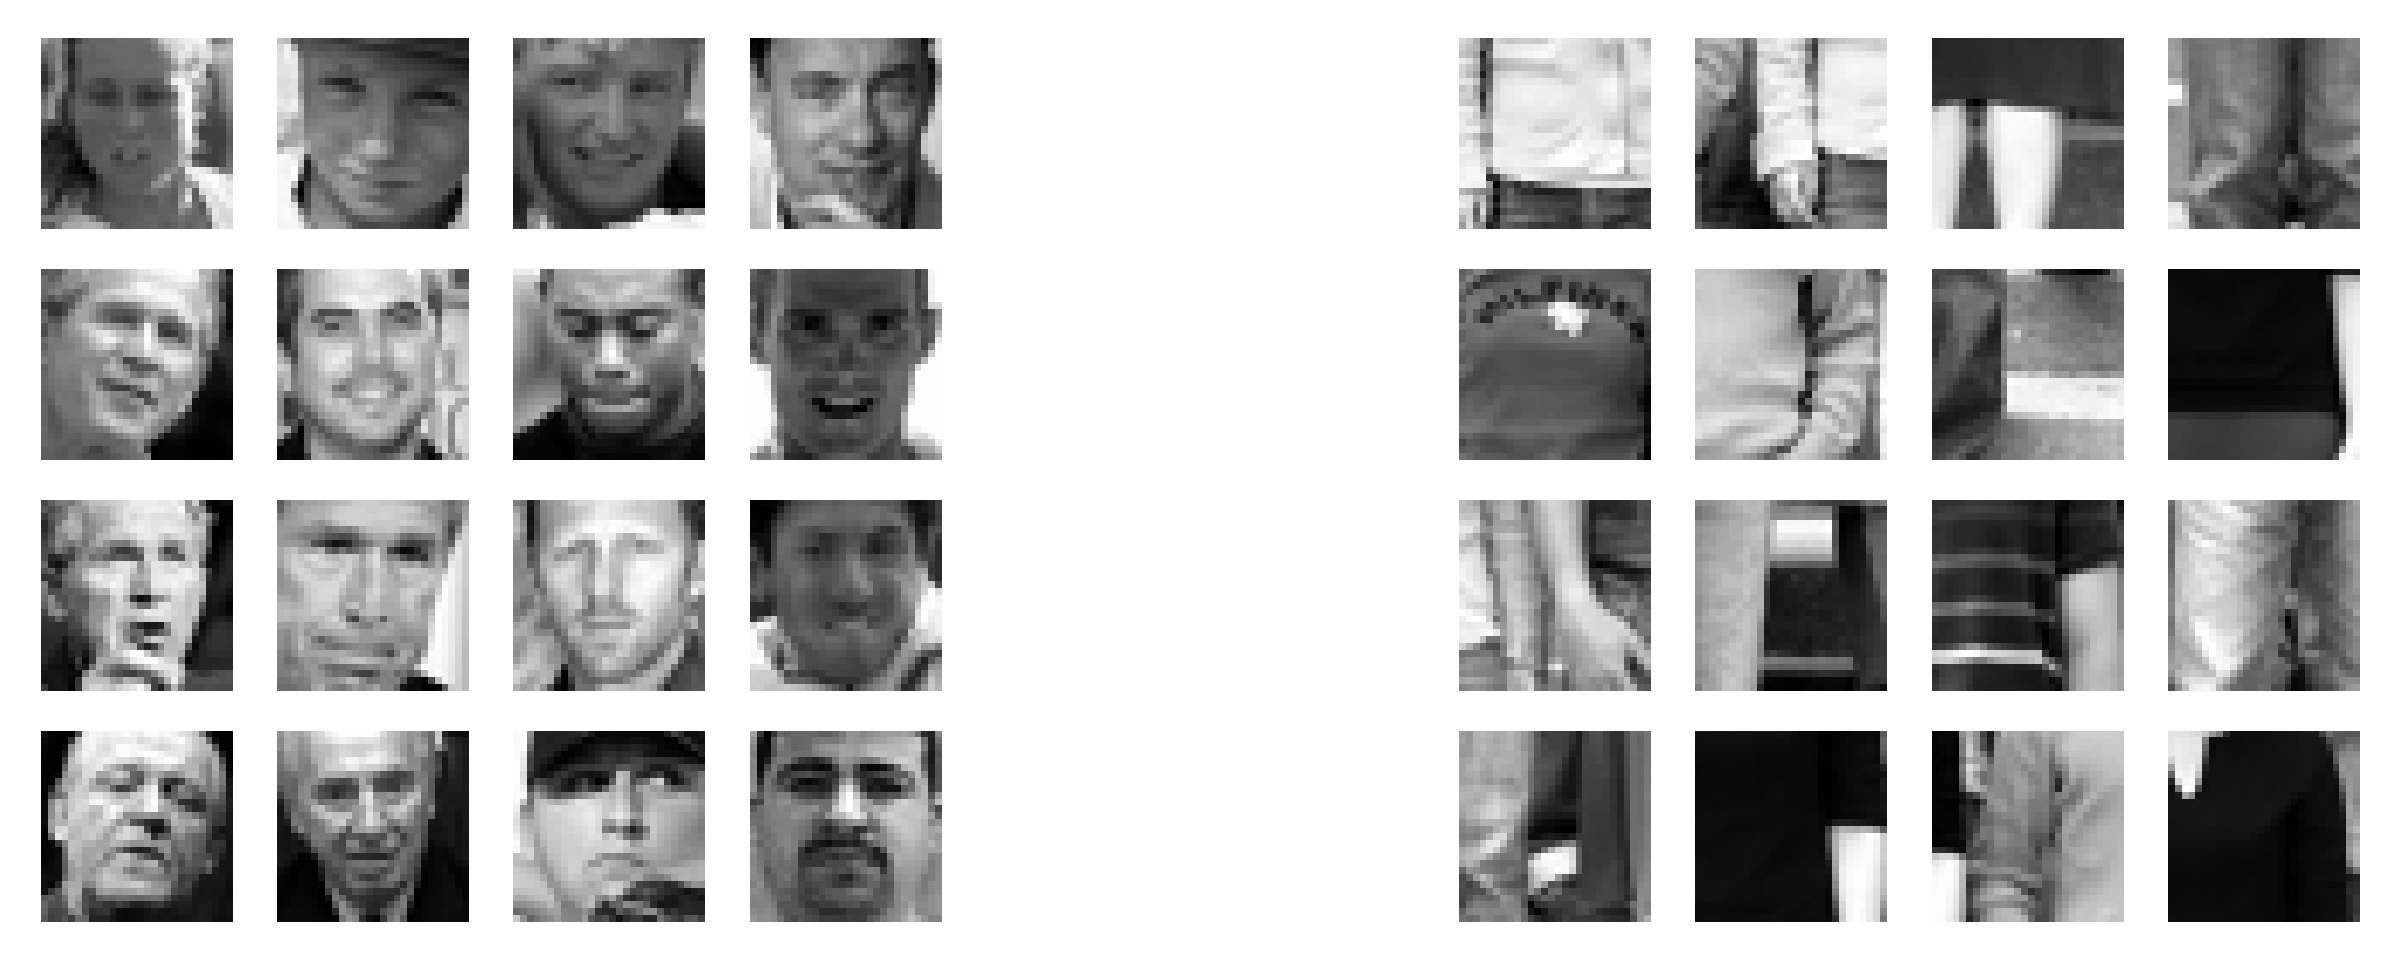

In [18]:
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10,4))
gs=GridSpec(4,10)

for i in range(0, 16):
    fig.add_subplot(gs[i%4 + int(i/4)*10])
    plt.imshow(X_square[i,:,:], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.axis('off')
    
    fig.add_subplot(gs[6 + i%4+int(i/4)*10])
    plt.imshow(X_square[9998-i,:,:], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.axis('off')    
    
plt.show()

----

Now we create a set of fixed convolution features (using edge detecting kernels) - first using our naive implementation ``naive_conv_layer``.

In [40]:
# start timer
startTime= time.time() 

feature_maps_1 = naive_conv_test.conv_layer(x,edge_detection_kernels)

# finish timing
timeElapsed=time.time()-startTime 
print('Time elpased in seconds:', timeElapsed)

Time elpased in seconds: 94.39337015151978


And our more effecient tensor-based implementation ``tensor_conv_layer``.

In [19]:
# start timer
startTime= time.time() 

feature_maps_2 = tensor_conv_test.conv_layer(x,edge_detection_kernels)

# finish timing
timeElapsed=time.time()-startTime 
print('Time elpased in seconds:', timeElapsed)
print(np.shape(feature_maps_2))

Time elpased in seconds: 0.31844186782836914
(1000, 512)


Wow!  That's around three orders of magnitude faster. Compare numerically each computation below.

In [41]:
np.linalg.norm(feature_maps_1-feature_maps_2)

4.8357429832731845e-15

<a id='footnotes'></a>

## Footnotes

\* A natural image is an image a human being would normally be exposed to like a forest or outdoor scene, cityscapes, other people, animals, the insides of buildings, etc.  

<a id='bib_cell'></a>

## References

[1] Horace Barlow. Redundancy reduction revisited. Network: Computation in Neural Systems, 12(3) 241–253, 2001.

[2] Horace Barlow. The coding of sensory messages. In Current Problems in Animal Behavior, pp. 331–360, 1961.

[3] Judson P Jones and Larry A Palmer. An evaluation of the two-dimensional gabor filter model of simple receptive fields in cat striate cortex. Journal of Neurophysiology, 58(6)1233–1258, 1987.

[4] Stjepan Marcelja. Mathematical description of the responses of simple cortical cells. JOSA, 70(11) 1297–1300, 1980. 

[5] Navneet Dalal and Bill Triggs. Histograms of oriented gradients for human detection. In Computer Vision and Pattern Recognition, 2005. CVPR 2005. IEEE Computer Society Conference on, volume 1, pp. 886–893. IEEE, 2005.

[6] David G. Lowe. Distinctive image features from scale-invariant keypoints. International Journal of Computer Vision, 60(2) 91–110, 2004.

[7] Jianguo Zhang et al. Local features and kernels for classification of texture and object categories: A comprehensive study. International Journal of Computer Vision 73(2) 213–238, 2007.